# Importing Libraries

In [155]:
import keras
import math
import os
import time
import random
import PIL
import glob
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from functools import partial
from sklearn.model_selection import KFold
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [156]:
(trainX, trainy), (_, _) = mnist.load_data()

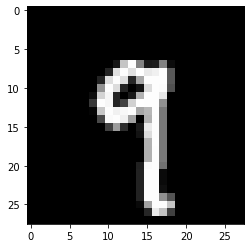

In [157]:
plt.imshow(trainX[176], cmap='gray')

In [158]:
# trainX = trainX.astype('float32') / 255
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1).astype('float32')
trainX = (trainX - 127.5) / 127.5
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1]*trainX.shape[2])

In [159]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

In [160]:
train_dataset = tf.data.Dataset.from_tensor_slices(trainX).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [161]:
trainy[trainy != 5] = 0
trainy[trainy == 5] = 1
len(trainy[trainy == 1])

5421

In [162]:
all_rows = []
i_nr = 0
for i in range(len(trainy)):
    if (trainy[i] == 1): 
        all_rows.append(i)

# deleting first 95% values (5421*0.95 = 5150) for value 5
drop_rows = all_rows[:5150]
pick_rows = all_rows[5150:]

trainX1 = np.delete(trainX, drop_rows, axis=0)
trainy1 = np.delete(trainy, drop_rows, axis=0)

print(trainX1.shape)
print(trainy1.shape)
print(len(trainy1[trainy1 == 1]))                 # should be 271
# 54850 + 5150 (rows dropped) = 60k

(54850, 784)
(54850,)
271


In [163]:
trainX2 = trainX[pick_rows]

In [164]:
trainX2 = trainX2.reshape((271, 28, 28, 1))

In [165]:
# stratified sampling
trainX1 = trainX1.reshape((54850, 28, 28, 1))
trainy1 = tf.keras.utils.to_categorical(trainy1)

x_train, x_test, y_train, y_test = train_test_split(trainX1, trainy1, test_size=0.2, stratify=trainy1, random_state=146) 

In [166]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

In [167]:
model.compile(optimizer = "nadam", loss = "binary_crossentropy", metrics = ["accuracy", tf.keras.metrics.Recall()])
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 4)

Epoch 1/4
1372/1372 [==============================] - 10s 6ms/step - loss: 0.0141 - accuracy: 0.9956 - recall_4: 0.9956 - val_loss: 0.0093 - val_accuracy: 0.9966 - val_recall_4: 0.9966
Epoch 2/4
1372/1372 [==============================] - 8s 6ms/step - loss: 0.0070 - accuracy: 0.9979 - recall_4: 0.9979 - val_loss: 0.0061 - val_accuracy: 0.9992 - val_recall_4: 0.9992
Epoch 3/4
1372/1372 [==============================] - 8s 6ms/step - loss: 0.0043 - accuracy: 0.9987 - recall_4: 0.9987 - val_loss: 0.0056 - val_accuracy: 0.9990 - val_recall_4: 0.9990
Epoch 4/4
1372/1372 [==============================] - 8s 6ms/step - loss: 0.0030 - accuracy: 0.9991 - recall_4: 0.9991 - val_loss: 0.0046 - val_accuracy: 0.9990 - val_recall_4: 0.9990


# Augmentation through GANs

In [168]:
def generator_model():
    model = keras.models.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers. LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

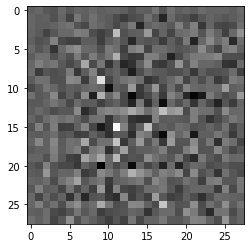

In [169]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [170]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # 1 output, prob of 5 vs not 5
    return model

In [171]:
discriminator = discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [172]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [173]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [174]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [175]:
EPOCHS = 1200
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [176]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [177]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [178]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [179]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        train_step(dataset)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Bootstrapping

# some 5 -> GAN = bad 5
# some 5 + bad 5 -> GAN = less bad 5
# some 5 + less bad 5 -> GAN = better 5

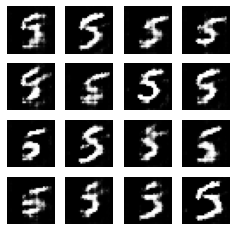

In [180]:
train(trainX2, EPOCHS)

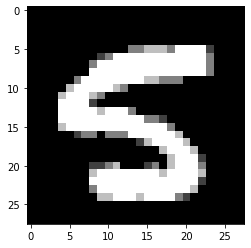

In [181]:
# actual 5s, we only train with the 5% 5s which are present in trainX2

p = random.randint(0,270)
plt.imshow(trainX2[p, :, :, 0], cmap='gray')

In [182]:
from numpy.random import randn

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# Currently within X, after removing 95% 5s, we have 54850 examples, out of which 271 are 5s.
# To equalise the balance i.e. 50-50%, we want 54850-271 = 54579 more 5s
# Augmenting data with synthetic 5s:

latent_points = generate_latent_points(100, 54579)
X = generator.predict(latent_points)
y = np.full((54579,2), [0.,1.])		# Because they are all 1s
X.shape

(54579, 28, 28, 1)

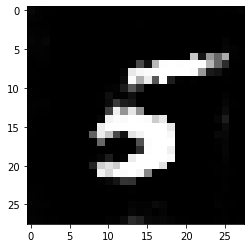

In [183]:
# 5s made by GAN

q = random.randint(0,54578)
plt.imshow(X[q, :, :, 0], cmap='gray')

In [184]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Training with the new 5s

In [185]:
# Adding new 5s test and train to old data

trainX1 = np.concatenate([trainX1, X], axis=0)
trainy1 = np.concatenate([trainy1, y], axis=0)

In [186]:
# stratified sampling

x_train, x_test, y_train, y_test = train_test_split(trainX1, trainy1, test_size=0.2, stratify=trainy1, random_state=146) 

In [187]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
model1.add(keras.layers.MaxPooling2D(pool_size=2))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.Dense(2, activation='softmax'))

In [188]:
model1.compile(optimizer = "nadam", loss = "binary_crossentropy", metrics = ["accuracy", tf.keras.metrics.Recall()])
model1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 4)

Epoch 1/4
2736/2736 [==============================] - 18s 6ms/step - loss: 0.0102 - accuracy: 0.9975 - recall_5: 0.9975 - val_loss: 0.0034 - val_accuracy: 0.9992 - val_recall_5: 0.9992
Epoch 2/4
2736/2736 [==============================] - 16s 6ms/step - loss: 0.0028 - accuracy: 0.9992 - recall_5: 0.9992 - val_loss: 0.0027 - val_accuracy: 0.9995 - val_recall_5: 0.9995
Epoch 3/4
2736/2736 [==============================] - 16s 6ms/step - loss: 0.0018 - accuracy: 0.9995 - recall_5: 0.9995 - val_loss: 0.0026 - val_accuracy: 0.9994 - val_recall_5: 0.9994
Epoch 4/4
2736/2736 [==============================] - 16s 6ms/step - loss: 0.0013 - accuracy: 0.9995 - recall_5: 0.9995 - val_loss: 0.0045 - val_accuracy: 0.9983 - val_recall_5: 0.9983


# Conclusion

The model with the GAN 5s performs better than the prior model. Our prior model barely had any 5s, which leads to unbalanced classes, and thus the lower accuracy.

Our new model works better now, given it trained with balanced classes. This also speaks well about our synthetic 5s generated through our GAN training.